# Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from sklearn import preprocessing
%matplotlib inline

df = pd.read_csv('/Users/jasongangel/Downloads/AIS/data/WorkOrder7538249_SAIS_2016-01.csv', usecols=['MMSI','PERIOD', 'Latitude', 'Longitude','SPEED_KNOTS', 'COG_DEG', 'SHIP_AND_CARGO_TYPE','DRAUGHT', 'DIM_BOW', 'DIM_STERN', 'DIM_STERN', 'DIM_PORT', 'DIM_STARBOARD'], na_values ='None',low_memory=False, parse_dates=['PERIOD'])

df = df.rename(columns={'Latitude': 'LAT', 'Longitude': 'LON', 'SHIP_AND_CARGO_TYPE':'SHIP_TYPE'})

# Datashader Geospatial Plot

CPU times: user 465 ms, sys: 121 ms, total: 586 ms
Wall time: 522 ms


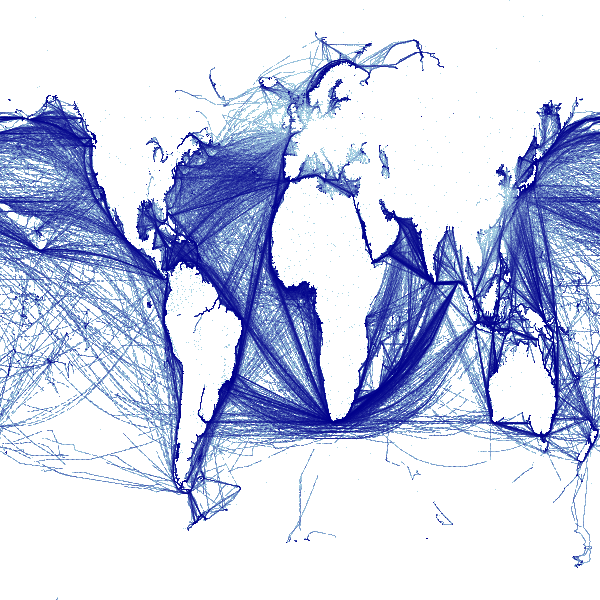

In [38]:
#DATASHADER
import datashader as ds
import datashader.transfer_functions as tf
import dask.dataframe as dd
dd = dd.read_csv('/Users/jasongangel/Downloads/AIS/data/WorkOrder7538249_SAIS_2016-01.csv', usecols=['Latitude','Longitude']).persist()

canvas = ds.Canvas(plot_width=500, plot_height=300, 
                   x_range=(-8,8), y_range=(-8,8), 
                   x_axis_type='linear', y_axis_type='linear')

%time tf.shade(ds.Canvas().points(dd,'Longitude','Latitude'))

#  Initial Data Look

In [39]:
df.head(5)

,MMSI,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,DIM_BOW,DIM_STERN,DIM_STARBOARD,DIM_PORT
0,229454000,2016-01-08 11:50:00,40.374271,-73.103733,15.9,92.0,79,10.0,212,92,18,22.0
1,229564000,2016-01-08 11:50:00,34.008233,-56.555884,11.9,73.0,70,13.6,197,28,11,21.0
2,229655000,2016-01-08 11:50:00,40.164743,-58.553108,19.1,59.9,70,12.9,244,90,16,27.0
3,249904000,2016-01-08 11:50:00,39.218795,-64.369931,18.0,72.1,70,9.9,40,225,11,21.0
4,209648000,2016-01-08 11:50:00,42.783833,-52.453734,11.7,290.5,70,16.4,246,43,21,24.0


In [40]:
#Dataframe Info (SHIP_TYPE and DRAUGHT contain bad str values thus they are detected as object type columns)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147784 entries, 0 to 7147783
Data columns (total 12 columns):
MMSI             int64
PERIOD           datetime64[ns]
LAT              float64
LON              float64
SPEED_KNOTS      float64
COG_DEG          float64
SHIP_TYPE        object
DRAUGHT          object
DIM_BOW          object
DIM_STERN        object
DIM_STARBOARD    int64
DIM_PORT         float64
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 2.0 GB


In [41]:
#Stats : COG_DEG should not exceed 360 and SPEED_KNOTS should not exceed 35kts
df.describe(include='all')

,MMSI,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,DIM_BOW,DIM_STERN,DIM_STARBOARD,DIM_PORT
count,7.147784e+06,7147784,7.147784e+06,7.147784e+06,7.142174e+06,7.126317e+06,7147784,7116768,7147784,7147784,7.147784e+06,7.147762e+06
unique,NaN,4870,NaN,NaN,NaN,NaN,53,248,338,306,NaN,NaN
top,NaN,2016-02-04 16:10:00,NaN,NaN,NaN,NaN,70,0.0,0,28,NaN,NaN
freq,NaN,3521,NaN,NaN,NaN,NaN,3888009,144891,158878,297678,NaN,NaN
first,NaN,2016-01-08 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-02-07 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.182158e+08,NaN,3.553690e+00,1.590313e+01,1.023094e+01,1.814406e+02,NaN,NaN,NaN,NaN,1.474211e+01,1.535881e+01
std,1.407346e+08,NaN,2.949682e+01,9.489613e+01,5.685175e+00,1.005541e+02,NaN,NaN,NaN,NaN,8.002065e+00,7.914598e+00
min,4.000000e+00,NaN,-8.748081e+01,-1.799997e+02,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,3.110040e+08,NaN,-2.170879e+01,-5.940824e+01,8.200000e+00,9.200000e+01,NaN,NaN,NaN,NaN,9.000000e+00,9.000000e+00


In [42]:
#Percentage of Rows w/ Missing Data
print((df.isnull().sum().sum()/df.shape[0])*100,'%')

0.8130491911898848 %


In [43]:
#Missing data per column
df.isnull().sum()

MMSI                 0
PERIOD               0
LAT                  0
LON                  0
SPEED_KNOTS       5610
COG_DEG          21467
SHIP_TYPE            0
DRAUGHT          31016
DIM_BOW              0
DIM_STERN            0
DIM_STARBOARD        0
DIM_PORT            22
dtype: int64

In [ ]:
#Number of individual Vessels
#print(df1['MMSI'].nunique(),'Individual Vessels')

# Data clean 

In [2]:
#Copy df
df1 = df.copy()

MMSI

In [3]:
#Remove invalid MMSIs
df1['MMSI'] = df1[(df1['MMSI'] > 200000000) & (df1['MMSI'] < 776000000)]

#Create Country Column from first three digits of MMSI
df1['MMSI'] = df1['MMSI'].astype(str)
df1['COUNTRY'] = df1['MMSI'].str.slice(start=0, stop=3)

#Drop MMSI Column
df1 = df1.drop(['MMSI'],axis=1)

PERIOD

In [4]:
df1 = df1.sort_values('PERIOD')

SPEED_KNOTS

In [5]:
#Drop null SPEED_KNOTS values
df1.dropna(how='any', axis=0, subset=['SPEED_KNOTS'], inplace=True)

#Drop Rows with speed over 35kts
df1=df1[df1.SPEED_KNOTS <= 35]

# SPEED_KNOTS Round to nearest 10th
df1['SPEED_KNOTS'] = df1['SPEED_KNOTS'].round(1)

COG_DEG

In [6]:
#Remove any COG_DEG values above 360
df1 = df1[(df1['COG_DEG'] <= 360)]

#Forward fill COG_DEG Null values 
df1['COG_DEG'] = df1['COG_DEG'].fillna(method='ffill')

#Remove excess float precision
df1['COG_DEG'] = df1['COG_DEG'].astype(int)

SHIP_TYPE and DRAUGHT

In [7]:
#Cast SHIP_TYPE  and DRAUGHT to numeric type and mark incompatable values as NAN
df1[['SHIP_TYPE','DRAUGHT','DIM_BOW', 'DIM_STERN', 'DIM_STARBOARD', 'DIM_PORT']] = df1[['SHIP_TYPE','DRAUGHT','DIM_BOW', 'DIM_STERN', 'DIM_STARBOARD', 'DIM_PORT']].apply(pd.to_numeric,errors='coerce',axis=0)

#Fill DRAUGHT null values with 0
df1['DRAUGHT']= df1['DRAUGHT'].fillna(0).round(1)

#Filter out vessel types other than Cargo and Tanker vessesls
df1 = df1[(df1['SHIP_TYPE'] >= 70) & (df1['SHIP_TYPE'] <= 89)]

#Cast SHIP_TYPE as a str
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].astype(str)

#Remove second digit of SHIP_TYPE (has no significance)
df1['SHIP_TYPE'] = df1['SHIP_TYPE'].str.slice(start=0, stop=1)

#Display count of unique vessel types
#df1.SHIP_TYPE.value_counts()

In [8]:
#Fill Null Dimension Values
df2 = df1.copy()
df2.update = df2[['DIM_BOW', 'DIM_STERN', 'DIM_STARBOARD', 'DIM_PORT']].astype(int).fillna(0)

In [9]:
#ADD DIM_BOW and DIM_STERN to get Length Overall (LOA) in Meters
df2['LENGTH_M'] = df2['DIM_BOW'] + df2['DIM_STERN']

In [10]:
#ADD DIM_PORT and DIM_STARBOARD to get Width Overall in Meters
df2['WIDTH_M'] = df2['DIM_PORT'] + df2['DIM_STARBOARD']

In [11]:
#Drop DIM_PORT, DIM_BOW, DIM_STERN, DIM_STARBOARD, DIM_PORT Columns
df2 = df2.drop(['DIM_BOW', 'DIM_STERN', 'DIM_STARBOARD', 'DIM_PORT'],axis=1)

# Clean Data Analysis

In [12]:
df2.head(10)

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY,LENGTH_M,WIDTH_M
0,2016-01-08 11:50:00,40.374271,-73.103733,15.9,92,7,10.0,229,304.0,40.0
130,2016-01-08 11:50:00,49.361491,-65.341650,15.6,97,8,8.7,249,127.0,20.0
131,2016-01-08 11:50:00,38.903676,-43.792365,14.8,278,7,12.4,352,336.0,46.0
135,2016-01-08 11:50:00,34.836016,-75.450617,8.7,228,7,12.3,477,323.0,43.0
136,2016-01-08 11:50:00,48.465194,-68.947389,13.5,53,7,10.1,477,200.0,24.0
137,2016-01-08 11:50:00,32.339833,-76.725695,10.0,207,7,9.7,259,199.0,31.0
138,2016-01-08 11:50:00,42.682120,-82.505487,9.5,13,7,5.2,367,212.0,22.0
139,2016-01-08 11:50:00,43.031976,-53.122365,11.6,107,7,16.6,441,269.0,43.0
140,2016-01-08 11:50:00,43.210504,-57.638380,16.7,95,7,10.5,266,293.0,33.0
141,2016-01-08 11:50:00,40.261499,-73.462667,15.6,304,7,9.6,271,183.0,28.0


In [14]:
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619850 entries, 0 to 7147783
Data columns (total 10 columns):
PERIOD         datetime64[ns]
LAT            float64
LON            float64
SPEED_KNOTS    float64
COG_DEG        int64
SHIP_TYPE      object
DRAUGHT        float64
COUNTRY        object
LENGTH_M       float64
WIDTH_M        float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 1.2 GB


In [15]:
df2.describe(include='all')

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,COUNTRY,LENGTH_M,WIDTH_M
count,6619850,6.619850e+06,6.619850e+06,6.619850e+06,6.619850e+06,6619850,6.619850e+06,6619850,6.619850e+06,6.619850e+06
unique,4870,NaN,NaN,NaN,NaN,2,NaN,204,NaN,NaN
top,2016-02-04 16:10:00,NaN,NaN,NaN,NaN,7,NaN,636,NaN,NaN
freq,3370,NaN,NaN,NaN,NaN,5000410,NaN,665761,NaN,NaN
first,2016-01-08 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-02-07 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.554137e+00,1.742173e+01,1.049013e+01,1.810509e+02,NaN,9.755522e+00,NaN,1.996982e+02,3.116688e+01
std,NaN,2.852722e+01,9.444177e+01,5.423864e+00,1.005282e+02,NaN,3.865326e+00,NaN,7.526939e+01,1.164588e+01
min,NaN,-8.748081e+01,-1.799997e+02,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,-2.111418e+01,-5.691257e+01,9.100000e+00,9.100000e+01,NaN,7.200000e+00,NaN,1.590000e+02,2.400000e+01


In [16]:
#Check again for null values
df2.isnull().sum()

PERIOD         0
LAT            0
LON            0
SPEED_KNOTS    0
COG_DEG        0
SHIP_TYPE      0
DRAUGHT        0
COUNTRY        0
LENGTH_M       0
WIDTH_M        0
dtype: int64

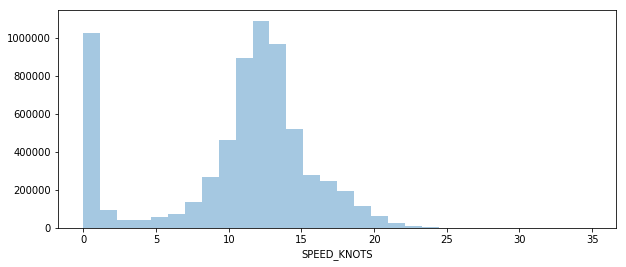

In [26]:
#SPEED_KNOTs Hist
plt.figure(figsize=(10,4))
sns.distplot(df2['SPEED_KNOTS'],kde=False,bins=30)

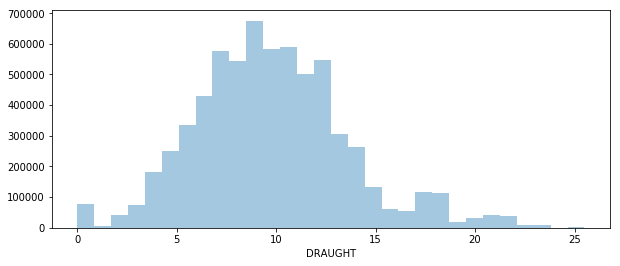

In [25]:
#DRAUGHT Hist
plt.figure(figsize=(10,4))
sns.distplot(df2['DRAUGHT'],kde=False,bins=30)

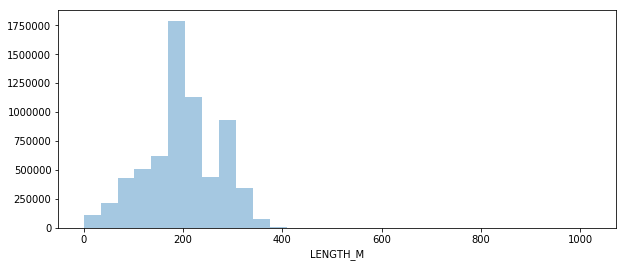

In [24]:
#LENGTH Hist
plt.figure(figsize=(10,4))
sns.distplot(df2['LENGTH_M'],kde=False,bins=30)

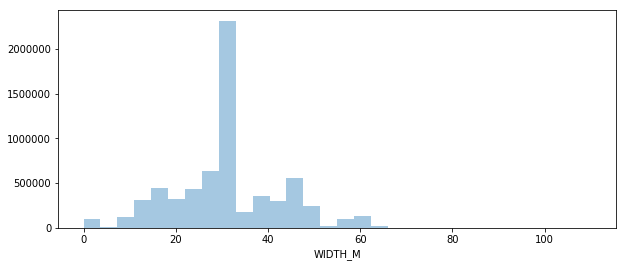

In [23]:
#WIDTH Hist
plt.figure(figsize=(10,4))
sns.distplot(df2['WIDTH_M'],kde=False,bins=30)

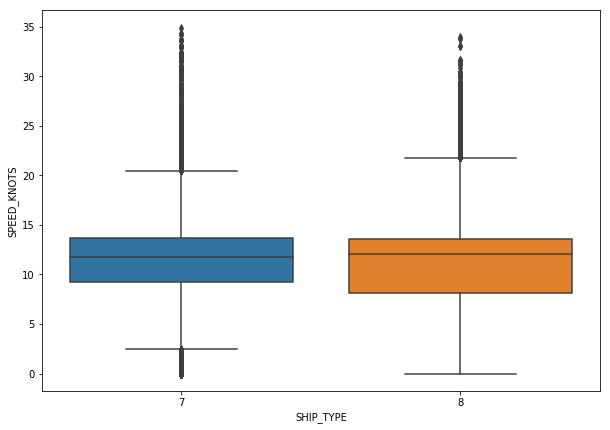

In [29]:
# Box Plot of SPEED_KNOTS by Cargo(7) and Tanker(8) vessels
plt.figure(figsize=(10,7))
sns.boxplot(x='SHIP_TYPE', y='SPEED_KNOTS',data=df1)

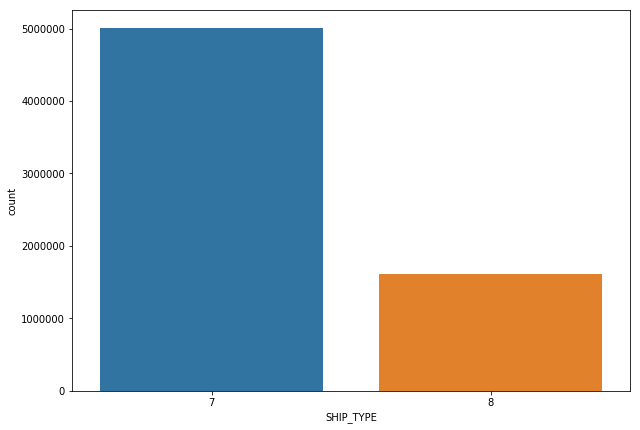

In [28]:
#Box Plot Count by SHIP_TYPE
plt.figure(figsize=(10,7))
sns.countplot(x='SHIP_TYPE',data=df1)

# Pre-Processing

In [30]:
df3 = df2.copy()

In [31]:
#Normalize Continuous Columns
import scipy
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df3[['LAT', 'LON', 'SPEED_KNOTS','DRAUGHT','COG_DEG','LENGTH_M', 'WIDTH_M']] = scaler.fit_transform(df3[['LAT', 'LON', 'SPEED_KNOTS','DRAUGHT','COG_DEG','LENGTH_M', 'WIDTH_M']])

In [32]:
#Binarize SHIP_TYPE (0 = CARGO, 1 = TANKER)
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df3["SHIP_TYPE"] = lb_make.fit_transform(df3["SHIP_TYPE"])

In [33]:
#One Hot Encode COUNTRY column
df3 = pd.get_dummies(df3, prefix=['CT_'],dummy_na=False)
df3 = df3.drop(['CT__nan'],axis=1)

In [34]:
df3.head()

,PERIOD,LAT,LON,SPEED_KNOTS,COG_DEG,SHIP_TYPE,DRAUGHT,LENGTH_M,WIDTH_M,CT__200,...,CT__725,CT__730,CT__735,CT__740,CT__750,CT__755,CT__760,CT__770,CT__773,CT__775
0,2016-01-08 11:50:00,0.723509,0.296935,0.455587,0.256267,0,0.392157,0.297456,0.363636,0,...,0,0,0,0,0,0,0,0,0,0
130,2016-01-08 11:50:00,0.774366,0.318497,0.446991,0.270195,1,0.341176,0.124266,0.181818,0,...,0,0,0,0,0,0,0,0,0,0
131,2016-01-08 11:50:00,0.715187,0.378356,0.424069,0.774373,0,0.486275,0.328767,0.418182,0,...,0,0,0,0,0,0,0,0,0,0
135,2016-01-08 11:50:00,0.692169,0.290416,0.249284,0.635097,0,0.482353,0.316047,0.390909,0,...,0,0,0,0,0,0,0,0,0,0
136,2016-01-08 11:50:00,0.769294,0.308481,0.386819,0.147632,0,0.396078,0.195695,0.218182,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619850 entries, 0 to 7147783
Columns: 212 entries, PERIOD to CT__775
dtypes: datetime64[ns](1), float64(7), int64(1), uint8(203)
memory usage: 1.7 GB


# Export

In [ ]:
#import csv
#df3.to_csv('/Users/jasongangel/Downloads/AIS/data/Clean/Clean-01_16*.csv', index=False, encoding='utf-8')
#quoting=csv.QUOTE_NONE

In [ ]:
#from pandas import HDFStore,DataFrame

# create (or open) an hdf5 file and opens in append mode
#hdf = HDFStore('AIS_ALL.h5')

# put the dataset in the storage
#hdf.put('d1', df3, format='table', data_columns=True)

#hdf.append()
        
#hdf.close() # closes the file

In [ ]:
#hdf = pd.read_hdf('AIS_ALL.h5', key='d1', mode='r')
#hdf.head()